In [1]:
# Install this package to use Colab's GPU for training
!sudo apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.4.1.50-1+cuda11.6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download and Inspect the Dataset|

In [3]:
import os

base_dir = '/content/drive/MyDrive/Colab Notebooks/data/'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/brain_tumor_dataset'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/val'))

Contents of base directory:
['val', 'brain_tumor_dataset']

Contents of train directory:
['no', 'yes']

Contents of validation directory:
['no', 'yes']


In [4]:
import os

train_dir = os.path.join(base_dir, 'brain_tumor_dataset')
validation_dir = os.path.join(base_dir, 'val')

# Directory with training yes/no pictures
train_yes_dir = os.path.join(train_dir, 'yes')
train_no_dir = os.path.join(train_dir, 'no')

# Directory with validation yes/no pictures
validation_yes_dir = os.path.join(validation_dir, 'yes')
validation_no_dir = os.path.join(validation_dir, 'no')

In [5]:
train_yes_fnames = os.listdir( train_yes_dir )
train_no_fnames = os.listdir( train_no_dir )

print(train_yes_fnames[:10])
print(train_no_fnames[:10])

['Y47.JPG', 'Y104.jpg', 'Y1.jpg', 'Y112.JPG', 'Y45.JPG', 'Y186.jpg', 'Y250.jpg', 'Y21.jpg', 'Y193.JPG', 'Y3.jpg']
['47 no.jpg', '43 no.jpg', '8 no.jpg', '11 no.jpg', 'N3.jpg', '9 no.jpg', 'no 89.jpg', '31 no.jpg', 'no 98.jpg', '6 no.jpg']


In [6]:
print('total training yes images :', len(os.listdir(      train_yes_dir ) ))
print('total training no images :', len(os.listdir(      train_no_dir ) ))

print('total validation yes images :', len(os.listdir( validation_yes_dir ) ))
print('total validation no images :', len(os.listdir( validation_no_dir ) ))

total training yes images : 155
total training no images : 98
total validation yes images : 155
total validation no images : 98


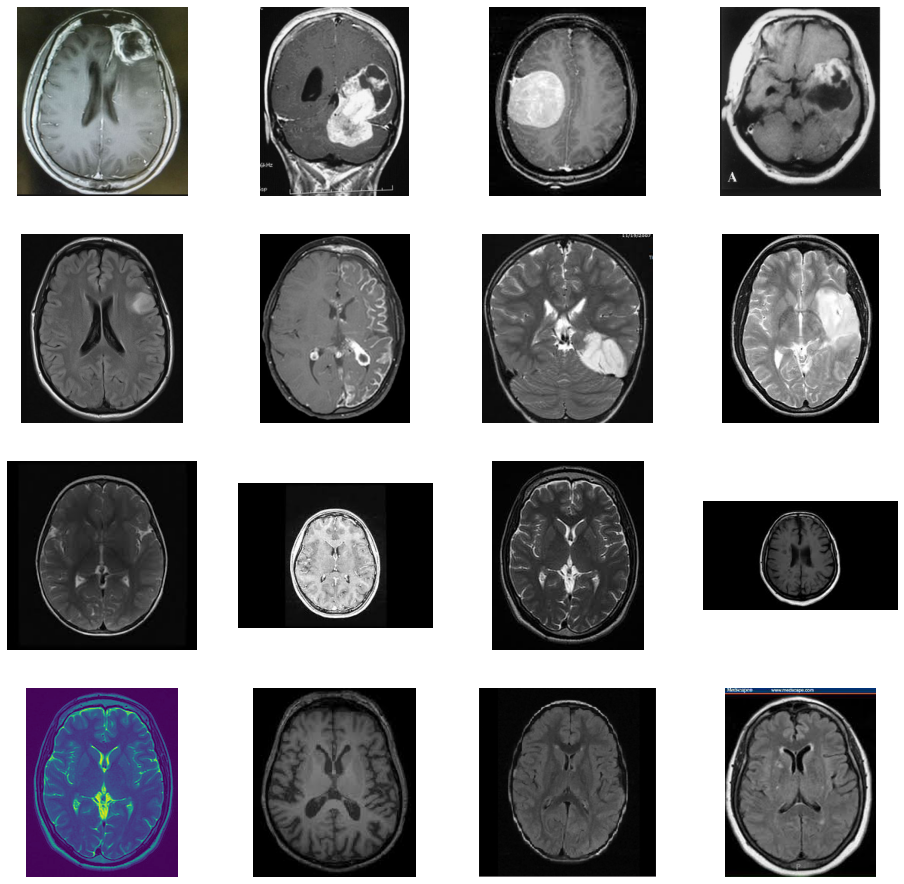

In [7]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_yes_pix = [os.path.join(train_yes_dir, fname) 
                for fname in train_yes_fnames[ pic_index-8:pic_index] 
               ]

next_no_pix = [os.path.join(train_no_dir, fname) 
                for fname in train_no_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_yes_pix+next_no_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 224, 224 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [10]:
from tensorflow.keras.optimizers import RMSprop,Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255 , 
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
test_datagen  = ImageDataGenerator( rescale = 1.0/255. ,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest' )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [12]:
history = model.fit(
            train_generator,
            epochs=25,
            validation_data=validation_generator,
            verbose=1
            )

Epoch 1/25
13/13 [==============================] - 51s 4s/step - loss: 0.7119 - accuracy: 0.5850 - val_loss: 0.6562 - val_accuracy: 0.6126
Epoch 2/25
13/13 [==============================] - 7s 565ms/step - loss: 0.6429 - accuracy: 0.6245 - val_loss: 0.6063 - val_accuracy: 0.6798
Epoch 3/25
13/13 [==============================] - 8s 629ms/step - loss: 0.5872 - accuracy: 0.6996 - val_loss: 0.5782 - val_accuracy: 0.7075
Epoch 4/25
13/13 [==============================] - 7s 566ms/step - loss: 0.6015 - accuracy: 0.6759 - val_loss: 0.5831 - val_accuracy: 0.6719
Epoch 5/25
13/13 [==============================] - 7s 563ms/step - loss: 0.6080 - accuracy: 0.6838 - val_loss: 0.5849 - val_accuracy: 0.7510
Epoch 6/25
13/13 [==============================] - 7s 559ms/step - loss: 0.5901 - accuracy: 0.6877 - val_loss: 0.5498 - val_accuracy: 0.7233
Epoch 7/25
13/13 [==============================] - 7s 563ms/step - loss: 0.5217 - accuracy: 0.7589 - val_loss: 0.5145 - val_accuracy: 0.7470
Epoch 8/

Text(0.5, 1.0, 'Training and validation loss')

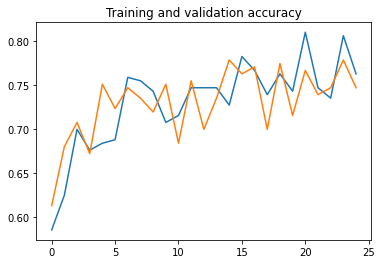

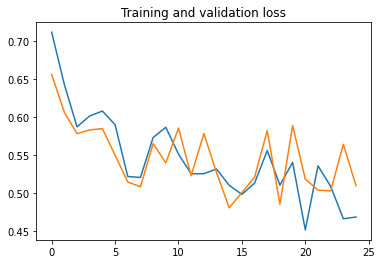

In [13]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [18]:
model.save('/content/drive/MyDrive/Colab Notebooks/data/CNN_tumor.h5')

In [23]:
 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
img_path =  '/content/drive/MyDrive/Colab Notebooks/data/brain_tumor_dataset/no/22 no.jpg'

img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255
model.predict(x)

1/1 [==============================] - 0s 21ms/step


array([[0.39402103]], dtype=float32)

In [22]:
 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
img_path =  '/content/drive/MyDrive/Colab Notebooks/data/brain_tumor_dataset/yes/Y105.jpg'

img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255
model.predict(x)

1/1 [==============================] - 0s 28ms/step


array([[0.98814243]], dtype=float32)